# Introduction
This tutorial illustrates how to (1) constrcut a PV system in the circuit , (2) visualise data and (3) change the inverter mode of PV system. The OpenDSS script is referenced from OpenDSS virtual training 2020 http://localhost:8888/notebooks/Desktop/Opendss/Jupyter%20project/Tutorial_2%23PV_system.ipynb

### (1) Constrcut a PV system in the circuit
A PVsystem element is defined by the following parameters, please be aware that naming of paramater is not intuitive.
- phases,bus1, kV, kVA pf: as discussed in tutorial 1
- EffCurve: inverter's per-unit efficiency verus its per-unit of rated kVA
- Pmpp: rated max active power of the PV system assuming 1.0 kW/sq-m irradiance
- Daily/yearly: set the per-unit irridiance value against time across day/year
- Irradiance: per-unit scaling of the above. default value is 1
- Tdaily, Tyearly: Tdaily and Tyearly defines the temeperature across a day or year respectively
- Temperature: similar to above but it sets the temperature as a constant for the simulatiom 
- P-TCurve: per-unit Pmpp versus temperature. 

At linear region of PV output, we have
PV panels output= Pmpp * {irridiance * (Daily or yearly)} * {P-TCurve at T=(Tdaily or Tyearly or Temperature)}  

In [1]:
import os
import pandas as pd;
import numpy as np
import opendssdirect as dss
#import matplotlib as plt
os.chdir('C:\\Users\\TAM048\\Desktop\\Opendss\\Jupyter project\\Tutorial 2 PV system') #remember to change the directory first
dss.run_command('Redirect PV_day3.dss')
dss.Basic.AllowEditor(False)

### (2) Visualise data
Although OpenDSS can solve a simulation effectively, its plotting function is rather limited. To visualise the simulation results, it is recommended to use other programs, e.g. python, MATLAB or Excel to create plot. Below is an example illustrating plotting of data using Excel.

Firstly, we export two csv files storing the change of power against time. monitor m1 stores information of both active and reactive power whereas m2 stores that of apparent power.

In [2]:
dss.run_command('show monitor m1');
dss.run_command('show monitor m2');

Now, we will read the csv file and get some plots using pandas.

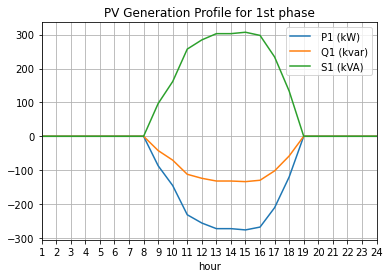

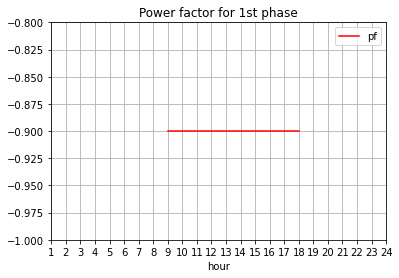

In [3]:
def power_plot():
    #Read the csv files
    m1_data=pd.read_csv("TheveninEquivalent_Mon_m1.csv",header=0);
    m2_data=pd.read_csv("TheveninEquivalent_Mon_m2.csv",header=0);

    #Stores 1st-phase power information in array
    t=m1_data['hour']; #x-axis, time in hour
    P1=m1_data[' P1 (kW)']; #active power
    Q1=m1_data[' Q1 (kvar)'] #reactive power
    S1=m2_data[' S1 (kVA)'] #apparent power
    pf=round(P1/S1,2); #power factor

    df=[t,P1,Q1,S1]
    df=(pd.DataFrame(df)).T
    df['pf']=pf
    #print(pf)  #uncomment if you want to see how pf changes with time

    #plot the dataframe
    df.plot(x='hour',y=df.columns[1:-1],grid=True,xticks=np.arange(1,25),
            title='PV Generation Profile for 1st phase',xlim=[1,24])
    df.plot(x='hour',y=df.columns[-1],grid=True,xticks=np.arange(1,25),
            title='Power factor for 1st phase',xlim=[1,24],ylim=[-1,-0.8],color='r')
power_plot()


###  (3) Change the inverter mode of PV system
Now, we will practise how to simulate differernt setting of inverter mode.

Firstly, we will study the base case of inverter, which the inverter will turn on or off when power generated by PV arrays is higher or lower than 20% of the rated kVA. This setting involved the following parameters: 
- %cutin: percentage of kVA rating required to turn on the inveter
- %cutout: percentage of kVA rating to shut down the inverter when the PV genetation is too weak.

In [4]:
dss.run_command('Reset Monitor') 
dss.run_command('set Time=(0,0)')
dss.run_command('PVSystem.PV.%cutin=30') 
dss.run_command('PVSystem.PV.%cutout=30')                
dss.run_command('Solve')
dss.run_command('show monitor m1');
dss.run_command('show monitor m2');

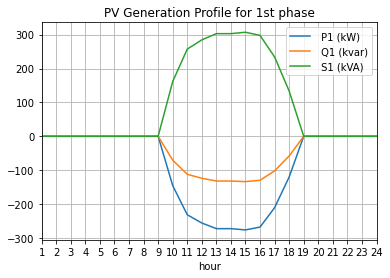

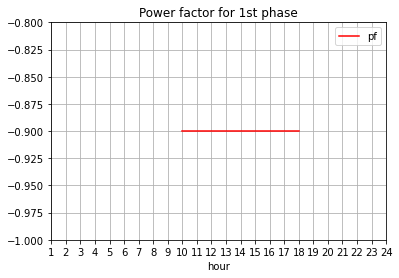

In [5]:
power_plot()

We can clearly see the introduction of inverter threshold only allows the generation of PV power from 09:00 instead of 08:00 compared with uncontrolled inverter (the previous graph).

Secondly, we will study the strategy of active-power-prioritised. It can be achieved using the parameter wattpriority
- WattPriority: if set to 'Yes', active power will be prioritised with reactive reactive power output reduced upon high   kVA. The Opposite happens when set to 'No', which is the default setting.

We will now set the mode of inverter to be active-power-prioritised with kVA rating modified in order exagerrate the effect of inveter's change

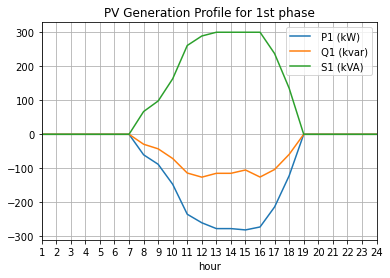

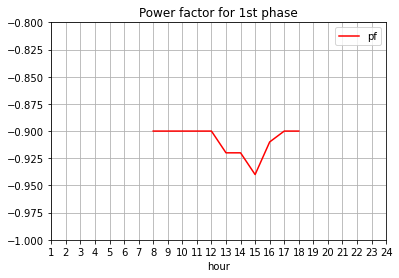

In [6]:
dss.run_command('Redirect PV_day3.dss')#read the original file instead of the one with modified inverter
dss.run_command('Reset Monitor'); 
dss.run_command('set Time=(0,0)');
dss.run_command('PVsystem.PV.WattPriority=Yes');
dss.run_command('PVsystem.PV.kVA=900');
dss.run_command('Solve')
dss.run_command('show monitor m1');
dss.run_command('show monitor m2');
power_plot()

We can see that the <span style='color:red'>magnitude</span> of power factor increases when kVA reaches the limit 300 kVA (900/3), which shows that active power is priorised.